In [11]:
from keras.preprocessing import image
from keras import metrics
from keras import losses
from keras import models, layers,Input
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
import keras
import tensorflow as tf
from PIL import Image
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from GradCAM import grad_cam

from keras import metrics
from keras import losses
from keras import models, layers,Input


In [6]:
model = load_model('densenetmodel.keras')

c:\Users\devas\miniconda3\envs\venv\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1210 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [17]:
Class_labels = ['negative', 'positive']
#image ='african_elephant.jpg'
image ="image2.png"
img = load_img(image, target_size=(224, 224))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
predicted_class = Class_labels[predicted_class]
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


'negative'

In [61]:
last_conv_layer_name = "conv5_block32_concat" # Name of the last convolutional layer
classifier_layer_names = [ # Names of the classifier layers from denseNet
    "bn",
    "relu"                        
]
cln =['global_average_pooling2d_2','dropout_2','dense_2'] # Names of the classifier layers from top layers
cut_off = 0.5 # Cut off value for binary classification
metricsVec = [ # Metrics to be used for evaluation
    metrics.BinaryAccuracy(threshold=cut_off),
    metrics.Precision(thresholds=cut_off),
    metrics.Recall(thresholds=cut_off),
    metrics.AUC(),
#     CohenKappa(num_classes=2),
#     cohen_kappa_score,
#     kappa_loss,
#     cohen_kappa,
#     cohen_kappa,
#     tf.python.ops.metric_ops.cohen_kappa,
]

# Seperating top layers from the model

top_layer = model.get_layer('Top_Layers')

# Preprocessing the image

def preprocess_image(image): 
    img = load_img(image, target_size=(224, 224)) # Load the image
    img_array = keras.preprocessing.image.img_to_array(img) # Convert image to numpy array
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    return img_array,img

In [19]:

Output_layer = model.get_layer('Base_DenseNet201').get_layer('densenet201') # Getting the base model of the DenseNet201
Output_layer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001*3),  # Optimizer with learning rate of 0.001*3 
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=metricsVec)

#Output_layer.summary()

Output_layer.name



'densenet201'

In [20]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    conv_layer = model.get_layer(last_conv_layer_name)
    # conv_layer = model.get_layer('Base_DenseNet201').get_layer('densenet201').get_layer(last_conv_layer_name)
    grad_model = keras.models.Model(
        model.inputs, conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    for layer_name in cln:
        x = top_layer.get_layer(layer_name)(x)    
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
     # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = grad_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

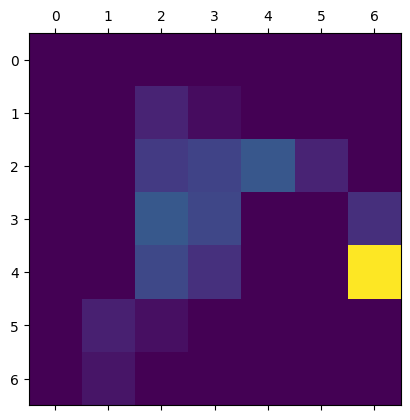

In [21]:
heatmap, top_index = make_gradcam_heatmap(img_array, Output_layer, last_conv_layer_name, classifier_layer_names) # Generate heatmap

# Display heatmap
plt.matshow(heatmap)
plt.show()



C:\Users\devas\AppData\Local\Temp\ipykernel_28368\461018288.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


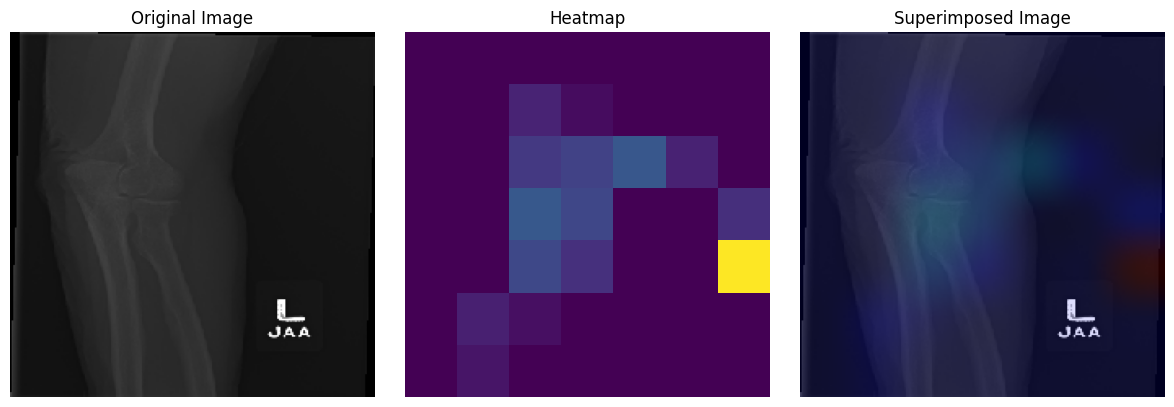

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import keras

# Load the image
#img_path = "image2.png"  # Replace "your_image_path.jpg" with the path to your image
#img_path = "image2.png"

def Display_Visualizations(image,label=None):

    img_array,img = preprocess_image(image)


    # Load the heatmap (assuming you already have it)
    #heatmap = np.random.rand(224, 224)  # Replace this with your actual heatmap
    heatmap, top_index = make_gradcam_heatmap(img_array, Output_layer, last_conv_layer_name, classifier_layer_names)

    # Preprocess the heatmap
    img_array = tf.squeeze(img_array, axis=0)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Get RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.3 + img_array
    #superimposed_img /= np.max(superimposed_img)
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save("grad_cam.jpg")

    # Arrange the images in a grid
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].axis("off")
    axs[0].set_title("Original Image")

    axs[1].imshow(heatmap)
    axs[1].axis("off")
    axs[1].set_title("Heatmap")

    axs[2].imshow(superimposed_img)
    axs[2].axis("off")
    axs[2].set_title("Superimposed Image")

    if label:
        axs[0].set_title(f"Original Image ({label})")
    plt.tight_layout()
    plt.show()

img_path = "image2.png"
Display_Visualizations(img_path)


C:\Users\devas\AppData\Local\Temp\ipykernel_28368\461018288.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


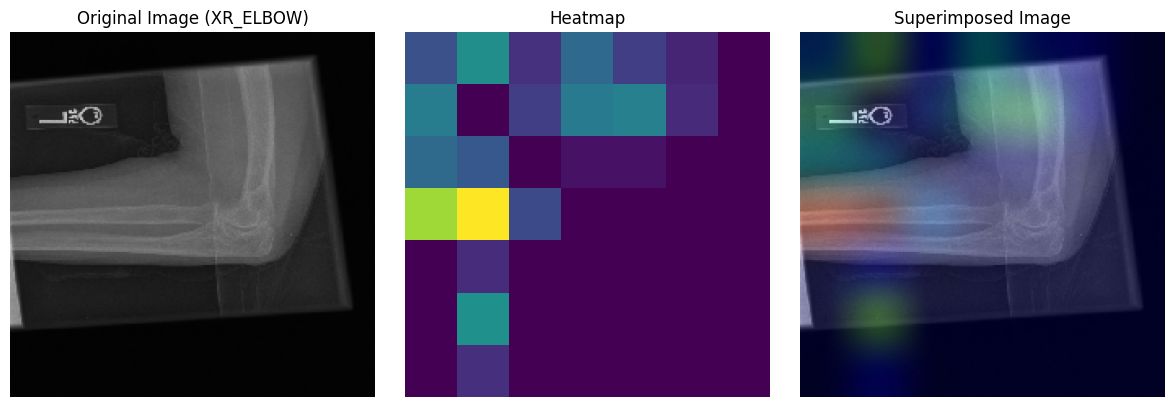

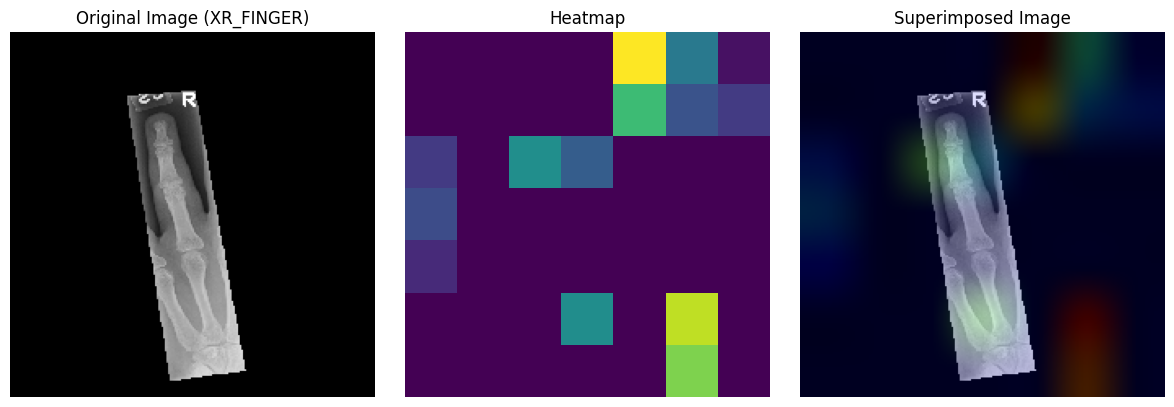

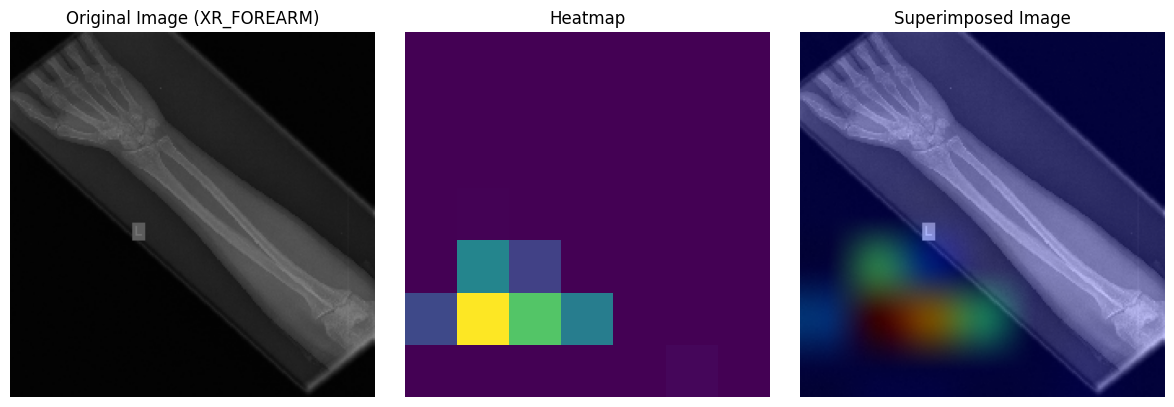

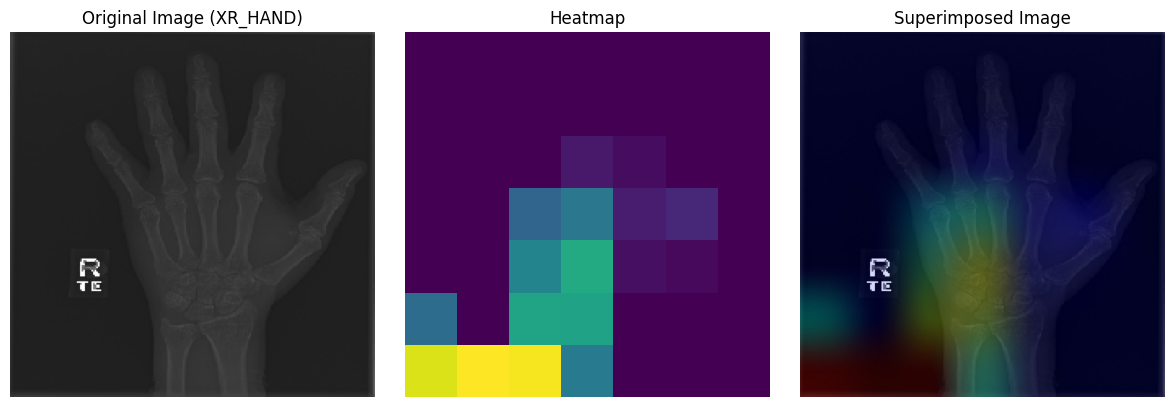

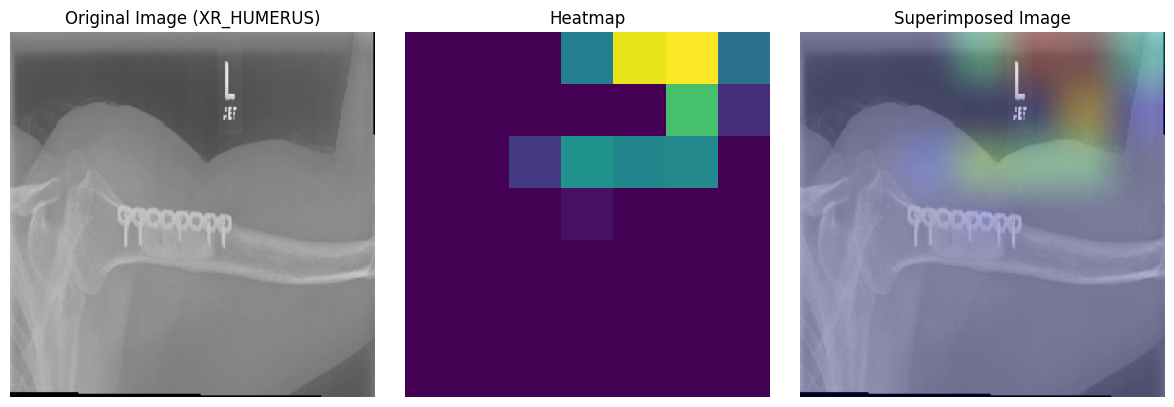

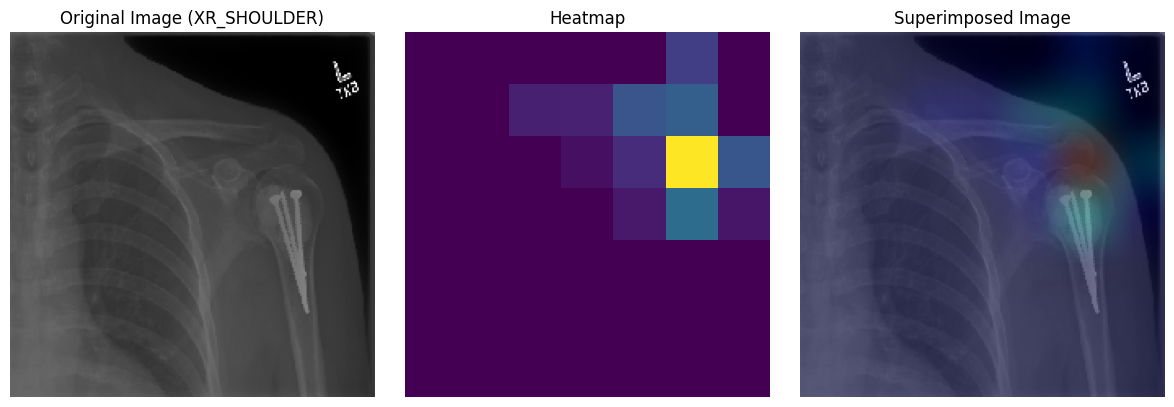

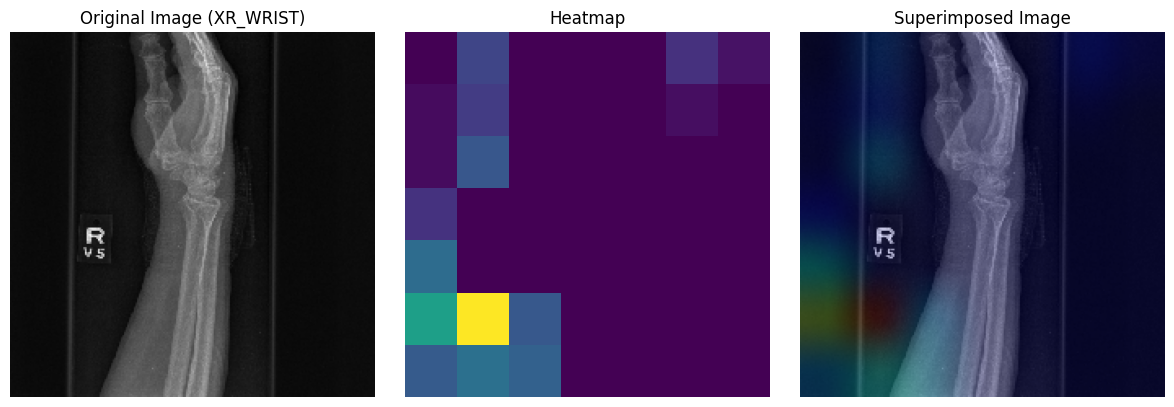

In [66]:
# Loop through the images and display the visualizations for each class

Dataset_Path = "MURA-v1.1/valid"

import os
import random

# Get the list of classes
classes = os.listdir(Dataset_Path)

# Loop through the classes
for class_name in classes:
    # Get the list of studies in the class
    class_path = os.path.join(Dataset_Path, class_name)
    patients = os.listdir(class_path)
    random_patient = random.choice(patients)
    patient_path = os.path.join(class_path, random_patient)

    # Get the list of studeis for the patient
    studies = os.listdir(patient_path)

    # get a random folder from class
    random_study = random.choice(studies)

    # Get the list of images in the study
    study_path = os.path.join(patient_path, random_study)

    images = os.listdir(study_path)
    # get a random image from folder
    random_image = random.choice(images)

    # Display the visualizations
    img_path = os.path.join(study_path, random_image)
    Display_Visualizations(img_path, class_name)


# Using GradCAM API

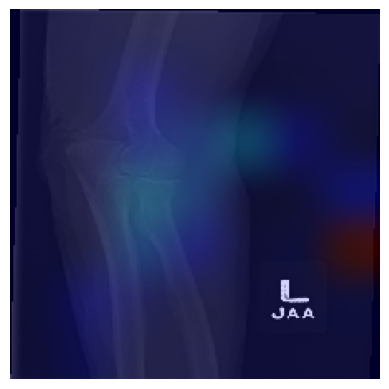

In [29]:

from GradCAM import grad_cam
from keras.preprocessing.image import load_img

image = 'image2.png'
image = preprocess_image(image)
# Initialize GradCAM object
gradcam = grad_cam(image,model='densenetmodel.keras',last_conv_layer_name=last_conv_layer_name,classifier_layer_names=classifier_layer_names)
plt.imshow(gradcam)
plt.axis('off')
plt.show()

